# core

> Fill in a module description here

In [1]:
# | default_exp lstm


In [2]:
# | hide
from nbdev.showdoc import *

In [3]:
# | export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from ts_vae_lstm.concepts import get_window
from scipy import signal
import os
import math
import torch

In [4]:
num_workers = os.cpu_count()
device = "cuda" if torch.cuda.is_available() else "cpu"
num_workers, device

(4, 'cuda')

Train a VAE with no anomalies in the time series.

```--> Anomalies occur at:
  timestamp #0: 2014-11-01 19:00:00
  timestamp #1: 2014-11-27 15:30:00
  timestamp #2: 2014-12-25 15:00:00
  timestamp #3: 2015-01-01 01:00:00
  timestamp #4: 2015-01-27 00:00:00

Original csv file contains (10320,) timestamps.
Processed time series contain (10320,) readings.
Anomaly indices are [5943, 7184, 8527, 8835, 10081]

Training set mean is 14855.115757575757
Training set std is 6556.134705703313
Anomaly indices in the test set are [2643 3884 5227 5535 6781]```

In [5]:
data = np.load("../sample_data/nyc_taxi.npz")
df = pd.DataFrame(data["training"], index=data["t_train"], columns=["value"])
df.head(2)


,value
1,-0.647416
2,-1.048144


In [6]:
# | export

from torch import nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score


In [7]:
# | export
from ts_vae_lstm.vae import VAE, Encoder, Decoder, StochasticSampler
from fastcore.xtras import noop


t
t_unit
readings
idx_anomaly
idx_split
training
test
train_m
train_std
t_train
t_test
idx_anomaly_test


Take `k` embeddings and predict the next `k` embeddings.

In [8]:
vae_model = torch.load("../models/vae_500_z24.pth", map_location="cpu")

In [9]:
# window_size = 10  # predict 10*30=300 minutes ahead
p = (
    48
    # so that one window is one day and the model can predict ahead one day
)

data = [
    {
        "subset": get_window(
            df.values,
            window_size=p,
            end_step=t,
            indices=list(df.index),
            return_indices=False,
        ),
        "end_step": t,
        "start_step": t - p,
    }
    for t in range(
        p, len(df), p
    )  # take steps every 48 so that we end up with non-overlapping sequences
]


In [10]:
len(data)

114

In [11]:
import numpy as np


@torch.no_grad()
def get_embeddings(x, n_windows=1, latent_dim=32, seq_len=1, sampler_repeat=200):
    """
    _summary_

    Parameters
    ----------
    x : _type_
        _description_
    n_windows : int, optional
        _description_, by default 1
    latent_dim : int, optional
        _description_, by default 32
    seq_len : int, optional
        _description_, by default 1
    sampler_repeat : int, optional
        Number of times to repeatedly sample from the sampler to ensure we have enough variablity in the embedding, by default 10

    Returns
    -------
    _type_
        _description_
    """
    # actual_shape = x.shape[0]
    x = torch.from_numpy(x.astype(np.float32)).view(
        n_windows, -1, seq_len
    )  # p, seq -> n_windows, p, seq
    embedded_x = torch.zeros(n_windows, latent_dim, seq_len)
    for idx in range(n_windows):
        batched_x_window = x[idx].unsqueeze(0)
        # print(batched_x_window.shape)
        z_mean, z_log_var = vae_model.encoder(batched_x_window)
        for _ in range(sampler_repeat):
            # explore multiple potential future embeddings by sampling from the latent space multiple times (Monte Carlo sampling).
            embedded_x[idx] += (
                vae_model.latent_sampler(z_mean, z_log_var).permute(1, 0)
                / sampler_repeat
            )

        # reshape
    embedded_x = embedded_x.reshape(latent_dim * n_windows, -1)
    return embedded_x


In [12]:
data[0]["subset"].shape


(48, 1)

In [13]:
get_embeddings(data[0]["subset"], latent_dim=24)


tensor([[-0.0436],
        [ 0.0054],
        [ 0.0026],
        [-0.1361],
        [-0.0288],
        [ 0.0071],
        [-0.6029],
        [-0.0372],
        [-0.0671],
        [ 0.0033],
        [-0.1059],
        [-0.4916],
        [-0.1029],
        [-0.0099],
        [-0.0390],
        [ 0.8928],
        [ 0.0221],
        [-0.0544],
        [-0.0587],
        [ 0.0125],
        [-0.0189],
        [ 0.0918],
        [ 1.6103],
        [ 0.0109]])

In [14]:
data_embeddings = [
    {
        "subset": get_embeddings(
            data[i]["subset"], latent_dim=24, n_windows=1, seq_len=1, sampler_repeat=200
        ),
        "end_step": data[i]["end_step"],
        "start_step": data[i]["start_step"],
    }
    for i in range(len(data))
]


In [15]:
len(data_embeddings)

114

In [16]:
data_embeddings[0]["subset"].shape

torch.Size([24, 1])

Preseve 10% of the dataset from this for validation set.
But be sure to preserve the order of the dataset, ie the next window is the target, so preserve that info well.

In [17]:
# dont include last index as this will cause value error
range_choices = range(len(data_embeddings) - 1)
val_data_idxs = np.random.choice(
    range_choices, size=int(0.2 * len(data_embeddings)), replace=False
)
val_data_idxs = [idx for idx in val_data_idxs]
print(val_data_idxs)
trn_data_idxs = [idx for idx in range_choices if idx not in val_data_idxs]
len(val_data_idxs), len(trn_data_idxs)


[27, 98, 22, 67, 81, 103, 74, 92, 93, 23, 87, 44, 26, 63, 101, 48, 5, 49, 36, 112, 29, 60]


(22, 91)

In [18]:
# | export


class TSLSTMDataset(Dataset):
    def __init__(
        self,
        embeddings,  # full dataset (not separated as we need to index the next window)
        indices,
        window_size=48,
        latent_dim=32,
        n_features=1,
        n_prev_windows=1,
        mean=0,
        std=1,
    ):
        self.embeddings = embeddings
        self.indices = indices
        self.mean = mean
        self.std = std
        self.n_prev_windows = n_prev_windows
        self.window_size = window_size
        self.latent_dim = latent_dim
        self.n_features = n_features

    def __getitem__(self, idx):
        true_idx = self.indices[idx]
        true_idx_next = true_idx + 1
        x_emb = self.embeddings[true_idx]["subset"]
        y_emb = self.embeddings[true_idx_next]["subset"]
        return x_emb, y_emb  # latent_dim, seq_len

    def __len__(self):
        return len(self.indices) - 1


In [19]:
means, stds = 0, 1
dset_trn = TSLSTMDataset(
    data_embeddings,
    indices=trn_data_idxs,
    mean=means,
    std=stds,
)

dset_val = TSLSTMDataset(
    data_embeddings,
    indices=val_data_idxs,
    mean=means,
    std=stds,
)  # use same stats from training data

In [20]:
# verify if loading works for all indices
x_emb, y_emb = [dset_trn[i] for i in range(len(dset_trn))][0]
x_emb, y_emb = [dset_val[i] for i in range(len(dset_val))][0]


In [21]:
x_emb.shape, y_emb.shape, y_emb.device, x_emb.requires_grad, y_emb.requires_grad

(torch.Size([24, 1]), torch.Size([24, 1]), device(type='cpu'), False, False)

In [22]:
x_emb.mean(), y_emb.mean()


(tensor(-0.0076), tensor(0.0703))

The embdeddings for the same dataset will be differnt (if we pass x to the get_embedding function in two different calls within the train dataset. Here we avoid this by generating embeddings in advance and storing it.) due to the Stochastic Sampling layer in VAE. 

In [23]:
x_emb.flatten()

tensor([-0.0105,  0.1434, -0.0486,  0.1512,  0.1276,  0.0437, -0.4014,  0.0739,
        -0.0247,  0.0580, -0.0141, -0.4561, -0.0702, -0.0820, -0.0072,  0.5125,
        -1.2658, -0.1198,  0.0890, -0.0909,  0.0447, -0.0211,  1.2134, -0.0274])

In [24]:
y_emb.flatten()

tensor([ 1.9343e-01, -9.7950e-04,  8.5595e-02, -7.7506e-02, -3.0638e-02,
         3.7606e-02, -6.3197e-01,  2.4139e-02, -2.5311e-03,  1.1221e-01,
         4.5496e-02, -2.6683e-01, -4.2849e-02,  3.4783e-02,  5.2905e-03,
         8.9389e-01, -2.5540e-01,  5.5886e-02,  3.5652e-02, -6.8229e-02,
         6.8086e-02,  2.8598e-02,  1.5365e+00, -9.2528e-02])

In [25]:
batch_size = 8


In [26]:
dl_trn = DataLoader(
    dataset=dset_trn,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=num_workers,
)
dl_val = DataLoader(
    dataset=dset_val,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=num_workers,
)


In [27]:
xs, ys = next(iter(dl_trn))


In [28]:
xs.shape


torch.Size([8, 24, 1])

In [53]:
# | export
class LSTMModel(nn.Module):
    def __init__(
        self, input_size=32, hidden_size=128, output_size=32, activation=F.tanh
    ):
        super(LSTMModel, self).__init__()
        self.isz = input_size
        self.hsz = hidden_size
        self.osz = output_size
        self.lstm_input = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,  # output_size,
            num_layers=1,
            batch_first=True,
        )
        self.lstm_hidden = nn.LSTM(
            input_size=hidden_size,  # output_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.lstm_output = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=output_size,
            num_layers=1,
            batch_first=True,
        )
        self.activation = activation
        self.dropout = nn.Dropout(0.5)
        # F.tanh  # F.relu, F.tanh, F.sigmoid, F.leaky_relu, F.elu, F.selu, F.softplus, F.softmax

    def forward(self, x):
        # x has shape bs, emb_dim, seq_len (emb_dim=latent_dim, seq_len=1)
        x = x.permute(0, 2, 1)  # bs, seq_len, emb_dim
        # LSTM1
        lstm_out1, (h1, c1) = self.lstm_input(x)
        lstm_out1 = self.activation(self.dropout(lstm_out1))
        # LSTM2
        lstm_out2, _ = self.lstm_hidden(lstm_out1)
        lstm_out2 = self.activation(self.dropout(lstm_out2))
        # LSTM3
        lstm_out3, _ = self.lstm_output(lstm_out2)

        lstm_out3 = self.activation(lstm_out3)
        return lstm_out3.permute(0, 2, 1)  # bs, output_size, seq_len


In [30]:
xs.shape

torch.Size([8, 24, 1])

In [31]:
pred_ys = LSTMModel(
    input_size=24,
    output_size=24,
    hidden_size=128,
)(xs)
pred_ys.shape

torch.Size([8, 24, 1])

# Training loop

In [32]:
def get_sim_matrix(x):
    x = x / x.norm(dim=1, keepdim=True)
    return x @ x.T

In [33]:
F.huber_loss

<function torch.nn.functional.huber_loss(input: torch.Tensor, target: torch.Tensor, reduction: str = 'mean', delta: float = 1.0) -> torch.Tensor>

In [34]:
# | export


def loss_func_lstm(inputs, targets):
    bs = inputs.shape[0]
    distance = torch.norm(targets - inputs, dim=2)
    loss = torch.where(distance > 1, distance.pow(2), torch.clamp(1 - distance, min=0))
    return loss.sum((-1)).mean()
    # return loss


def huber_loss(inputs, targets):
    bs = inputs.shape[0]
    loss = F.huber_loss(inputs, targets, reduction="none", delta=3)
    # delta=0.05 cos the error in embedding space is really small
    return loss.sum((-1, -2)).mean()  # sum((-1, -2)).mean()
    # return loss


@torch.no_grad()
def mean_absolute_error(predictions, targets):
    error = torch.abs(predictions - targets)
    mae = torch.sum(error, dim=(-1, -2))
    return torch.mean(mae)


def calculate_smape(predicted, actual):
    absolute_percentage_errors = torch.abs(predicted - actual) / (
        torch.abs(predicted) + torch.abs(actual)
    )
    return absolute_percentage_errors.sum((-1, -2)).mean()


def scorer_lstm(inputs, targets):
    with torch.no_grad():
        return torch.pow(inputs.squeeze() - targets.squeeze(), 2).mean()

In [35]:
(
    loss_func_lstm(pred_ys, ys),
    scorer_lstm(pred_ys, ys),
    calculate_smape(pred_ys, ys),
    mean_absolute_error(pred_ys, ys),
    huber_loss(pred_ys, ys),
)


(tensor(22.7885, grad_fn=<MeanBackward0>),
 tensor(0.1700),
 tensor(18.2345, grad_fn=<MeanBackward0>),
 tensor(4.9035),
 tensor(2.0396, grad_fn=<MeanBackward0>))

In [36]:
a = torch.tensor([[1.0, 2], [3.0, 4], [5.0, 6]]).unsqueeze(-1)
b = torch.tensor([[3.0, 4], [5.0, 6], [7.0, 8]]).unsqueeze(-1)
a.shape, b.shape


(torch.Size([3, 2, 1]), torch.Size([3, 2, 1]))

In [37]:
# | export
from fastcore.xtras import partial


In [38]:
def scaled_func(func, scale=1, *args, **kwargs):
    def mod_func(*args, **kwargs):
        result = func(*args, **kwargs)
        return result * scale

    return mod_func


In [39]:
from fastcore.xtras import noop


Epoch [1/200], Batch [11/11], Loss: [1.913, 1.858], Score: [4.662, 4.562]
Epoch [2/200], Batch [11/11], Loss: [1.699, 1.595], Score: [4.387, 4.242]
Epoch [3/200], Batch [11/11], Loss: [1.401, 1.258], Score: [4.006, 3.808]
Epoch [4/200], Batch [11/11], Loss: [1.093, 0.984], Score: [3.618, 3.520]
Epoch [5/200], Batch [11/11], Loss: [0.894, 0.857], Score: [3.417, 3.386]
Epoch [6/200], Batch [11/11], Loss: [0.794, 0.817], Score: [3.261, 3.339]
Epoch [7/200], Batch [11/11], Loss: [0.776, 0.790], Score: [3.250, 3.298]
Epoch [8/200], Batch [11/11], Loss: [0.741, 0.758], Score: [3.193, 3.241]
Epoch [9/200], Batch [11/11], Loss: [0.712, 0.714], Score: [3.150, 3.162]
Epoch [10/200], Batch [11/11], Loss: [0.682, 0.689], Score: [3.084, 3.117]
Epoch [11/200], Batch [11/11], Loss: [0.653, 0.686], Score: [3.056, 3.126]
Epoch [12/200], Batch [11/11], Loss: [0.649, 0.660], Score: [3.025, 3.057]
Epoch [13/200], Batch [11/11], Loss: [0.646, 0.657], Score: [3.032, 3.067]
Epoch [14/200], Batch [11/11], Los

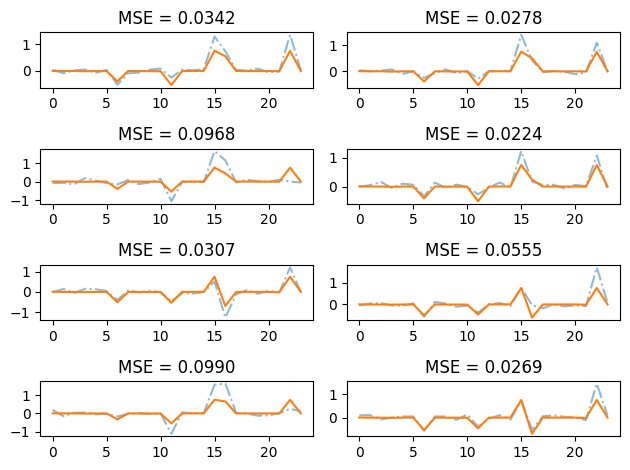

Epoch [20/200], Batch [11/11], Loss: [0.609, 0.633], Score: [2.948, 3.012]
Epoch [21/200], Batch [11/11], Loss: [0.613, 0.629], Score: [2.957, 3.017]
Epoch [22/200], Batch [11/11], Loss: [0.606, 0.624], Score: [2.949, 2.988]
Epoch [23/200], Batch [11/11], Loss: [0.612, 0.622], Score: [2.930, 2.996]
Epoch [24/200], Batch [11/11], Loss: [0.593, 0.620], Score: [2.904, 2.991]
Epoch [25/200], Batch [11/11], Loss: [0.599, 0.615], Score: [2.926, 2.979]
Epoch [26/200], Batch [11/11], Loss: [0.602, 0.612], Score: [2.942, 2.967]
Epoch [27/200], Batch [11/11], Loss: [0.596, 0.608], Score: [2.910, 2.939]
Epoch [28/200], Batch [11/11], Loss: [0.588, 0.604], Score: [2.902, 2.939]
Epoch [29/200], Batch [11/11], Loss: [0.591, 0.602], Score: [2.878, 2.931]
Epoch [30/200], Batch [11/11], Loss: [0.575, 0.601], Score: [2.843, 2.920]
Epoch [31/200], Batch [11/11], Loss: [0.581, 0.597], Score: [2.863, 2.920]
Epoch [32/200], Batch [11/11], Loss: [0.577, 0.592], Score: [2.858, 2.911]
Epoch [33/200], Batch [11

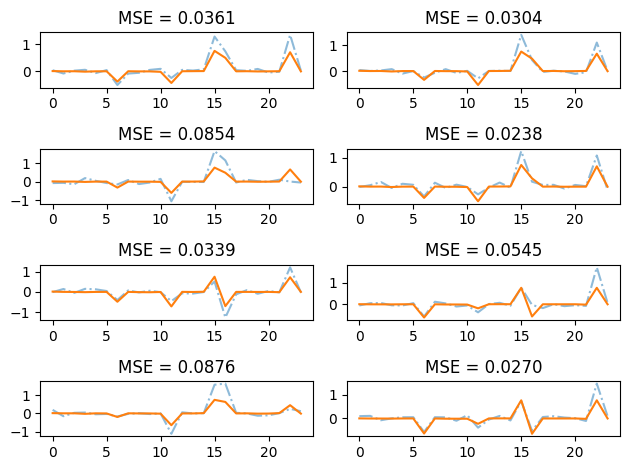

Epoch [40/200], Batch [11/11], Loss: [0.545, 0.528], Score: [2.787, 2.758]
Epoch [41/200], Batch [11/11], Loss: [0.543, 0.522], Score: [2.780, 2.743]
Epoch [42/200], Batch [11/11], Loss: [0.530, 0.520], Score: [2.763, 2.739]
Epoch [43/200], Batch [11/11], Loss: [0.519, 0.517], Score: [2.727, 2.728]
Epoch [44/200], Batch [11/11], Loss: [0.511, 0.521], Score: [2.718, 2.741]
Epoch [45/200], Batch [11/11], Loss: [0.529, 0.516], Score: [2.748, 2.730]
Epoch [46/200], Batch [11/11], Loss: [0.516, 0.511], Score: [2.736, 2.714]
Epoch [47/200], Batch [11/11], Loss: [0.504, 0.510], Score: [2.694, 2.717]
Epoch [48/200], Batch [11/11], Loss: [0.501, 0.507], Score: [2.700, 2.699]
Epoch [49/200], Batch [11/11], Loss: [0.510, 0.504], Score: [2.715, 2.686]
Epoch [50/200], Batch [11/11], Loss: [0.490, 0.507], Score: [2.669, 2.709]
Epoch [51/200], Batch [11/11], Loss: [0.488, 0.509], Score: [2.669, 2.719]
Epoch [52/200], Batch [11/11], Loss: [0.488, 0.505], Score: [2.648, 2.705]
Epoch [53/200], Batch [11

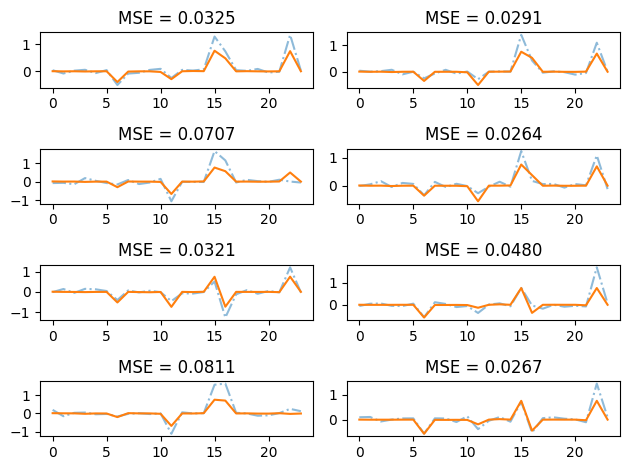

Epoch [60/200], Batch [11/11], Loss: [0.480, 0.489], Score: [2.638, 2.659]
Epoch [61/200], Batch [11/11], Loss: [0.476, 0.489], Score: [2.636, 2.653]
Epoch [62/200], Batch [11/11], Loss: [0.481, 0.486], Score: [2.622, 2.653]
Epoch [63/200], Batch [11/11], Loss: [0.465, 0.486], Score: [2.601, 2.652]
Epoch [64/200], Batch [11/11], Loss: [0.464, 0.479], Score: [2.584, 2.644]
Epoch [65/200], Batch [11/11], Loss: [0.466, 0.481], Score: [2.600, 2.648]
Epoch [66/200], Batch [11/11], Loss: [0.469, 0.487], Score: [2.606, 2.651]
Epoch [67/200], Batch [11/11], Loss: [0.460, 0.487], Score: [2.576, 2.652]
Epoch [68/200], Batch [11/11], Loss: [0.469, 0.493], Score: [2.605, 2.656]
Epoch [69/200], Batch [11/11], Loss: [0.462, 0.488], Score: [2.583, 2.645]
Epoch [70/200], Batch [11/11], Loss: [0.461, 0.486], Score: [2.573, 2.639]
Epoch [71/200], Batch [11/11], Loss: [0.465, 0.477], Score: [2.600, 2.621]
Epoch [72/200], Batch [11/11], Loss: [0.458, 0.474], Score: [2.563, 2.615]
Epoch [73/200], Batch [11

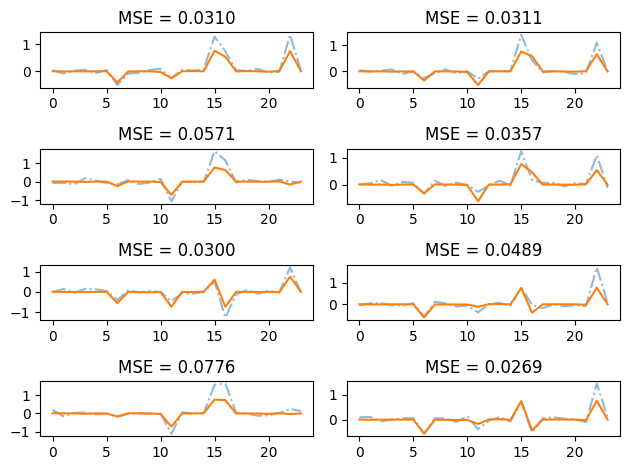

Epoch [80/200], Batch [11/11], Loss: [0.456, 0.485], Score: [2.546, 2.639]
Epoch [81/200], Batch [11/11], Loss: [0.450, 0.475], Score: [2.546, 2.618]
Epoch [82/200], Batch [11/11], Loss: [0.456, 0.476], Score: [2.575, 2.619]
Epoch [83/200], Batch [11/11], Loss: [0.446, 0.492], Score: [2.541, 2.654]
Epoch [84/200], Batch [11/11], Loss: [0.440, 0.482], Score: [2.515, 2.628]
Epoch [85/200], Batch [11/11], Loss: [0.441, 0.486], Score: [2.523, 2.635]
Epoch [86/200], Batch [11/11], Loss: [0.451, 0.488], Score: [2.542, 2.639]
Epoch 00086: reducing learning rate of group 0 to 9.0000e-04.
Epoch [87/200], Batch [11/11], Loss: [0.435, 0.466], Score: [2.505, 2.602]
Epoch [88/200], Batch [11/11], Loss: [0.448, 0.467], Score: [2.542, 2.598]
Epoch [89/200], Batch [11/11], Loss: [0.444, 0.476], Score: [2.521, 2.622]
Epoch [90/200], Batch [11/11], Loss: [0.442, 0.486], Score: [2.539, 2.645]
Epoch [91/200], Batch [11/11], Loss: [0.459, 0.475], Score: [2.550, 2.620]
Epoch [92/200], Batch [11/11], Loss: [

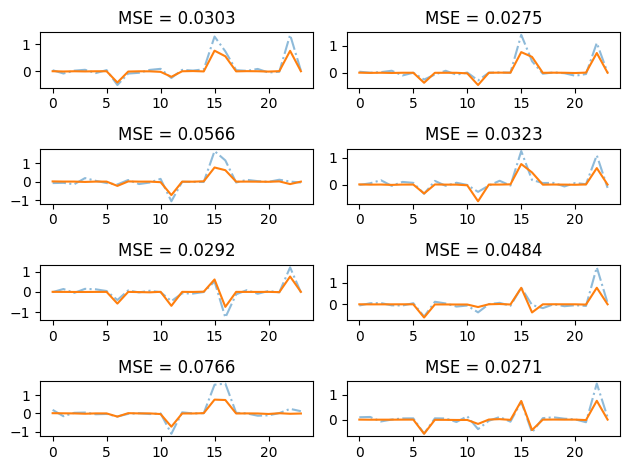

Epoch [100/200], Batch [11/11], Loss: [0.440, 0.467], Score: [2.512, 2.607]
Epoch [101/200], Batch [11/11], Loss: [0.439, 0.476], Score: [2.503, 2.619]
Epoch [102/200], Batch [11/11], Loss: [0.445, 0.490], Score: [2.533, 2.643]
Epoch [103/200], Batch [11/11], Loss: [0.434, 0.472], Score: [2.500, 2.611]
Epoch [104/200], Batch [11/11], Loss: [0.442, 0.465], Score: [2.520, 2.597]
Epoch [105/200], Batch [11/11], Loss: [0.436, 0.466], Score: [2.497, 2.595]
Epoch [106/200], Batch [11/11], Loss: [0.439, 0.465], Score: [2.520, 2.589]
Epoch [107/200], Batch [11/11], Loss: [0.428, 0.464], Score: [2.486, 2.588]
Epoch [108/200], Batch [11/11], Loss: [0.439, 0.467], Score: [2.512, 2.593]
Epoch [109/200], Batch [11/11], Loss: [0.443, 0.468], Score: [2.520, 2.591]
Epoch [110/200], Batch [11/11], Loss: [0.430, 0.470], Score: [2.479, 2.588]
Epoch 00110: reducing learning rate of group 0 to 8.1000e-04.
Epoch [111/200], Batch [11/11], Loss: [0.432, 0.465], Score: [2.492, 2.580]
Epoch [112/200], Batch [11

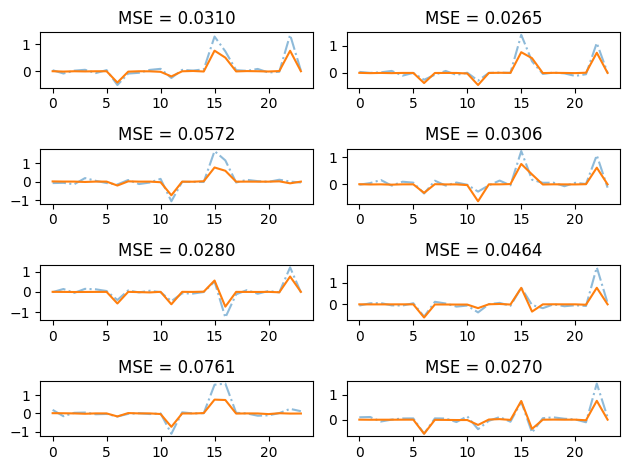

Epoch [120/200], Batch [11/11], Loss: [0.437, 0.462], Score: [2.485, 2.583]
Epoch [121/200], Batch [11/11], Loss: [0.441, 0.463], Score: [2.499, 2.584]
Epoch [122/200], Batch [11/11], Loss: [0.429, 0.462], Score: [2.471, 2.577]
Epoch [123/200], Batch [11/11], Loss: [0.432, 0.461], Score: [2.472, 2.576]
Epoch [124/200], Batch [11/11], Loss: [0.432, 0.459], Score: [2.475, 2.574]
Epoch [125/200], Batch [11/11], Loss: [0.426, 0.461], Score: [2.452, 2.579]
Epoch [126/200], Batch [11/11], Loss: [0.428, 0.468], Score: [2.476, 2.590]
Epoch [127/200], Batch [11/11], Loss: [0.426, 0.459], Score: [2.448, 2.577]
Epoch [128/200], Batch [11/11], Loss: [0.435, 0.459], Score: [2.488, 2.575]
Epoch [129/200], Batch [11/11], Loss: [0.428, 0.464], Score: [2.465, 2.584]
Epoch [130/200], Batch [11/11], Loss: [0.422, 0.464], Score: [2.452, 2.579]
Epoch [131/200], Batch [11/11], Loss: [0.430, 0.459], Score: [2.482, 2.577]
Epoch [132/200], Batch [11/11], Loss: [0.427, 0.463], Score: [2.454, 2.585]
Epoch [133/2

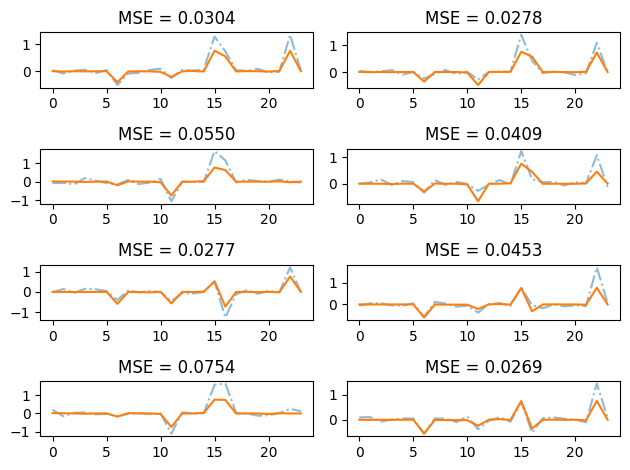

Epoch [140/200], Batch [11/11], Loss: [0.423, 0.465], Score: [2.445, 2.583]
Epoch [141/200], Batch [11/11], Loss: [0.427, 0.465], Score: [2.447, 2.582]
Epoch [142/200], Batch [11/11], Loss: [0.423, 0.464], Score: [2.434, 2.578]
Epoch [143/200], Batch [11/11], Loss: [0.430, 0.463], Score: [2.468, 2.580]
Epoch [144/200], Batch [11/11], Loss: [0.423, 0.463], Score: [2.445, 2.582]
Epoch [145/200], Batch [11/11], Loss: [0.422, 0.470], Score: [2.438, 2.591]
Epoch [146/200], Batch [11/11], Loss: [0.428, 0.470], Score: [2.454, 2.591]
Epoch [147/200], Batch [11/11], Loss: [0.426, 0.463], Score: [2.460, 2.581]
Epoch [148/200], Batch [11/11], Loss: [0.433, 0.462], Score: [2.461, 2.580]
Epoch [149/200], Batch [11/11], Loss: [0.425, 0.463], Score: [2.438, 2.583]
Epoch 00149: reducing learning rate of group 0 to 6.5610e-04.
Epoch [150/200], Batch [11/11], Loss: [0.422, 0.466], Score: [2.450, 2.591]
Epoch [151/200], Batch [11/11], Loss: [0.427, 0.464], Score: [2.446, 2.585]
Epoch [152/200], Batch [11

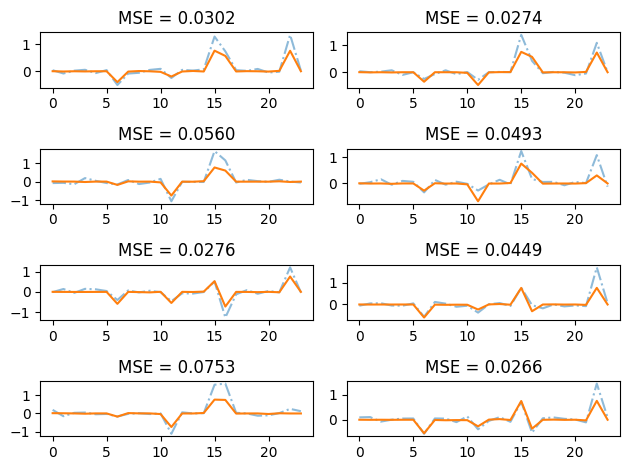

Epoch [160/200], Batch [11/11], Loss: [0.418, 0.470], Score: [2.422, 2.591]
Epoch 00160: reducing learning rate of group 0 to 5.9049e-04.
Epoch [161/200], Batch [11/11], Loss: [0.424, 0.467], Score: [2.449, 2.587]
Epoch [162/200], Batch [11/11], Loss: [0.419, 0.468], Score: [2.428, 2.587]
Epoch [163/200], Batch [11/11], Loss: [0.419, 0.467], Score: [2.441, 2.587]
Epoch [164/200], Batch [11/11], Loss: [0.429, 0.464], Score: [2.447, 2.578]
Epoch [165/200], Batch [11/11], Loss: [0.424, 0.461], Score: [2.425, 2.578]
Epoch [166/200], Batch [11/11], Loss: [0.424, 0.461], Score: [2.433, 2.580]
Epoch [167/200], Batch [11/11], Loss: [0.427, 0.469], Score: [2.440, 2.593]
Epoch [168/200], Batch [11/11], Loss: [0.422, 0.465], Score: [2.432, 2.594]
Epoch [169/200], Batch [11/11], Loss: [0.423, 0.474], Score: [2.438, 2.601]
Epoch [170/200], Batch [11/11], Loss: [0.419, 0.480], Score: [2.448, 2.605]
Epoch [171/200], Batch [11/11], Loss: [0.423, 0.480], Score: [2.435, 2.604]
Epoch 00171: reducing lear

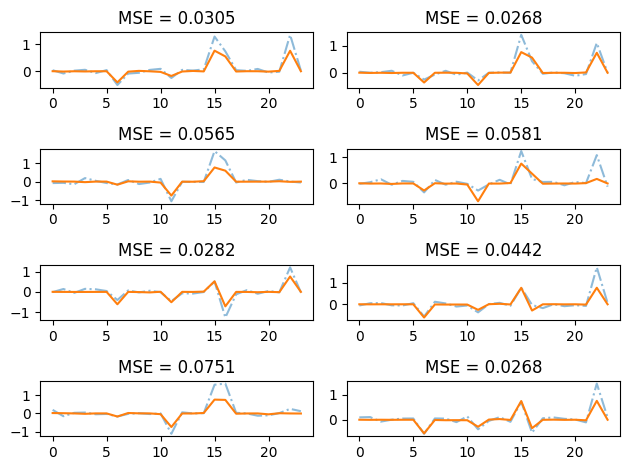

Epoch [180/200], Batch [11/11], Loss: [0.415, 0.477], Score: [2.420, 2.602]
Epoch [181/200], Batch [11/11], Loss: [0.411, 0.478], Score: [2.391, 2.603]
Epoch [182/200], Batch [11/11], Loss: [0.420, 0.487], Score: [2.409, 2.614]
Epoch 00182: reducing learning rate of group 0 to 4.7830e-04.
Epoch [183/200], Batch [11/11], Loss: [0.426, 0.491], Score: [2.430, 2.618]
Epoch [184/200], Batch [11/11], Loss: [0.419, 0.481], Score: [2.413, 2.606]
Epoch [185/200], Batch [11/11], Loss: [0.412, 0.469], Score: [2.407, 2.593]
Epoch [186/200], Batch [11/11], Loss: [0.425, 0.463], Score: [2.451, 2.580]
Epoch [187/200], Batch [11/11], Loss: [0.425, 0.471], Score: [2.438, 2.589]
Epoch [188/200], Batch [11/11], Loss: [0.420, 0.480], Score: [2.427, 2.607]
Epoch [189/200], Batch [11/11], Loss: [0.422, 0.483], Score: [2.445, 2.615]
Epoch [190/200], Batch [11/11], Loss: [0.421, 0.487], Score: [2.438, 2.618]
Epoch [191/200], Batch [11/11], Loss: [0.414, 0.484], Score: [2.392, 2.613]
Epoch [192/200], Batch [11

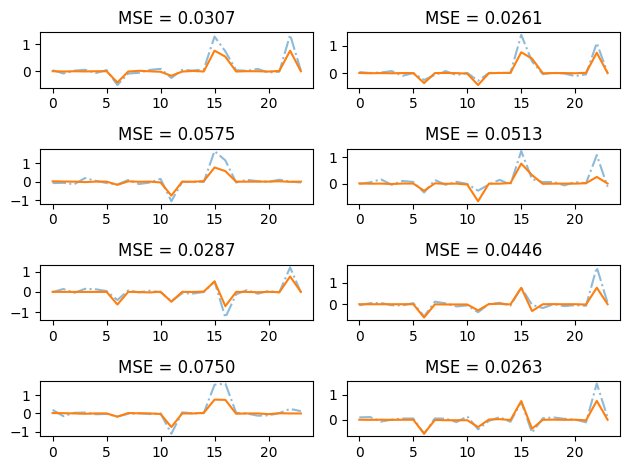

Epoch [200/200], Batch [11/11], Loss: [0.415, 0.472], Score: [2.412, 2.592]


In [40]:
train_dataloader = dl_trn
valid_dataloader = dl_val
batch_size = 16
num_epochs = 200
learning_rate = 1e-3
latent_dim = 24
hidden_size = 128
# dropout_p = 0.2
# num_layers = 2
# scale = 1
range_val = 3
activation = partial(F.hardtanh, min_val=-range_val, max_val=range_val)
criterion = huber_loss  # mean_absolute_error
scorer = mean_absolute_error

dset_trn = TSLSTMDataset(
    data,
    indices=trn_data_idxs,
    mean=means,
    std=stds,
)

dset_val = TSLSTMDataset(
    data,
    indices=val_data_idxs,
    mean=means,
    std=stds,
)  # use same stats from training data


dl_trn = DataLoader(
    dataset=dset_trn,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=num_workers,
)
dl_val = DataLoader(
    dataset=dset_val,
    batch_size=batch_size,
    drop_last=False,
    shuffle=False,
    num_workers=num_workers,
)


model = LSTMModel(
    input_size=latent_dim,
    output_size=latent_dim,
    hidden_size=hidden_size,
    activation=activation,
).to(device)


optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-6,
    # momentum=0.999,
    # nesterov=True,
)

# Training loop

print_every = len(train_dataloader)

# Define LR scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.9,
    patience=10,
    min_lr=1e-8,
    verbose=True,
)


# validation
def validate_epoch(dls, criterion, scorer, show=False):
    model.eval()
    running_loss = 0.0
    running_score = 0.0
    with torch.no_grad():
        for batch_idx, (xs, ys) in enumerate(dls):
            # move to device
            xs = xs.to(device)
            ys = ys.to(device)

            # Forward pass
            pred_ys = model(xs)

            loss = criterion(pred_ys, ys)
            # calc score
            score = scorer(pred_ys, ys)

            running_loss += loss.item()
            running_score += score.item()
        if show:
            for idx in range(batch_size):
                if idx >= 8:
                    break
                ax = plt.subplot(4, 2, idx + 1)
                # idx_feature = 0
                pred_current_example, current_points = (
                    pred_ys[idx].detach().cpu().squeeze(),
                    ys[idx].detach().cpu().squeeze(),
                )
                sns.lineplot(current_points.numpy(), alpha=0.5, linestyle="-.")
                sns.lineplot(pred_current_example.numpy())
                mse_val = F.mse_loss(pred_current_example, current_points)
                plt.title(f"MSE = {mse_val:.4f}")
            plt.tight_layout()
            plt.show()

    return running_loss / len(dls), running_score / len(dls)


# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_score = 0.0
    for batch_idx, (xs, ys) in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()

        # move to device
        xs = xs.to(device)
        ys = ys.to(device)

        # Forward pass
        pred_ys = model(xs)

        loss = criterion(pred_ys, ys)
        # calc score
        score = scorer(pred_ys, ys)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_score += score.item()
    # epoch ended
    if (batch_idx + 1) % print_every == 0:
        # calculate loss for valid_dataloader
        n_dls = len(train_dataloader)
        val_loss, val_score = validate_epoch(
            valid_dataloader, criterion, scorer, show=(epoch + 1) % 20 == 0
        )
        print(
            "Epoch [{}/{}], Batch [{}/{}], Loss: [{:.3f}, {:.3f}], Score: [{:.3f}, {:.3f}]".format(
                epoch + 1,
                num_epochs,
                batch_idx + 1,
                n_dls,
                running_loss / n_dls,
                val_loss,
                running_score / n_dls,
                val_score,
            )
        )
    # reset at end of epoch
    running_loss = 0.0
    running_score = 0.0
    # Step the LR scheduler
    scheduler.step(val_loss)  # min the running_loss

In [41]:
torch.save(model, f"../models/lstm_{num_epochs}.pth")
f"../models/lstm_{num_epochs}.pth"

'../models/lstm_200.pth'

# Inference

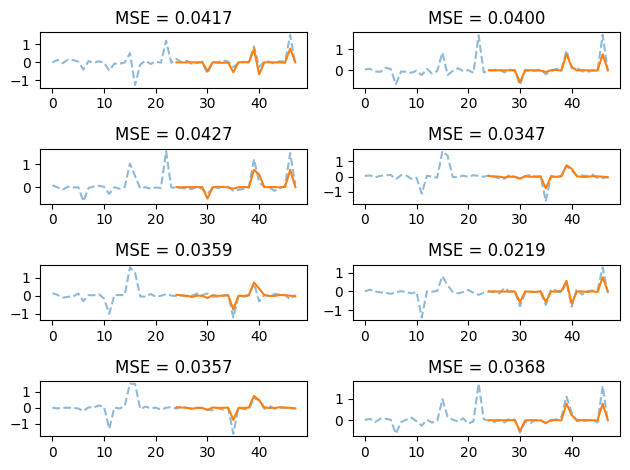

In [43]:
with torch.no_grad():
    model.eval()
    xs_val, ys_val = next(iter(valid_dataloader))
    pred_ys_val = model(xs_val.to(device))

    for idx in range(batch_size):
        if idx >= 8:
            break
        ax = plt.subplot(4, 2, idx + 1)
        # idx_feature = 0
        pred_current_example, current_points, prev_points = (
            pred_ys_val[idx].detach().cpu().squeeze(),
            ys_val[idx].detach().cpu().squeeze(),
            xs_val[idx].detach().cpu().squeeze(),
        )
        # sns.lineplot(prev_points.numpy(), alpha=0.5, label="prev true")
        sns.lineplot(
            np.concatenate([prev_points.numpy(), current_points.numpy()], axis=0),
            alpha=0.5,
            linestyle="--",
        )  # , label="next true")
        padded_pred = np.concatenate(
            [[None] * len(pred_current_example), pred_current_example.numpy()], axis=0
        )
        sns.lineplot(padded_pred)  # , label="next pred")
        mse_val = F.mse_loss(pred_current_example, current_points)
        # plt.ylim(-2, 2)
        plt.title(f"MSE = {mse_val:.4f}")
    plt.tight_layout()

In [44]:
len(padded_pred)

48

use a squared term if the absolute element-wise error falls below delta and a delta-scaled L1 term otherwise.

In [45]:
(pred_current_example - current_points).mean()

tensor(-0.0322)

# Reconstruct the time series 
Take the predicted embedding, pass it to the decoder of VAE to make the prediction.

In [46]:
pred_current_example.shape, current_points.shape


(torch.Size([24]), torch.Size([24]))

In [47]:
pred_ts_values = vae_model.decoder(pred_current_example.unsqueeze(0))
pred_ts_values_true = vae_model.decoder(current_points.unsqueeze(0))

In [48]:
pred_ts_values.shape

torch.Size([1, 48, 1])

In [49]:
F.mse_loss(pred_ts_values, pred_ts_values_true)

tensor(0.0709, grad_fn=<MseLossBackward0>)

Plot time series values decoded from embedding

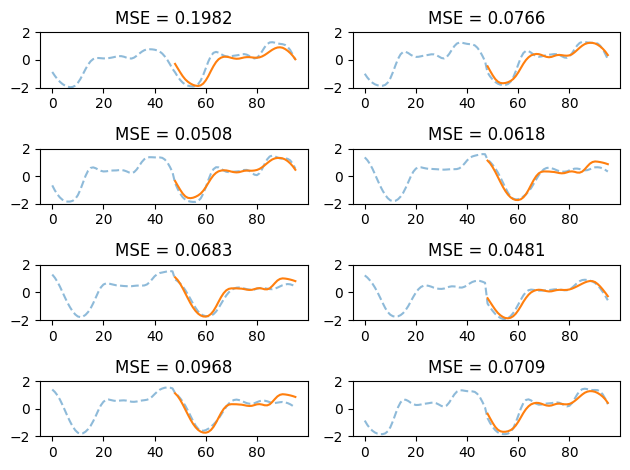

In [50]:
with torch.no_grad():
    xs_val, ys_val = next(iter(valid_dataloader))
    pred_ys_val = model(xs_val.to(device))

    for idx in range(batch_size):
        if idx >= 8:
            break
        ax = plt.subplot(4, 2, idx + 1)
        # idx_feature = 0
        pred_current_example, current_points, prev_points = (
            pred_ys_val[idx].detach().cpu().squeeze(),
            ys_val[idx].detach().cpu().squeeze(),
            xs_val[idx].detach().cpu().squeeze(),
        )
        pred_ts_prev = vae_model.decoder(prev_points.unsqueeze(0)).squeeze()
        pred_ts_values = vae_model.decoder(pred_current_example.unsqueeze(0)).squeeze()
        pred_ts_values_true = vae_model.decoder(current_points.unsqueeze(0)).squeeze()
        sns.lineplot(
            np.concatenate([pred_ts_prev.numpy(), pred_ts_values_true.numpy()], axis=0),
            alpha=0.5,
            linestyle="--",
        )  # , label="next true")
        padded_pred = np.concatenate(
            [[None] * len(pred_ts_values), pred_ts_values.numpy()], axis=0
        )
        sns.lineplot(padded_pred)
        mse_val = F.mse_loss(pred_ts_values, pred_ts_values_true)

        plt.ylim(-2, 2)
        plt.title(f"MSE = {mse_val:.4f}")

    plt.tight_layout()


In [51]:
torch.abs(pred_ts_values - pred_ts_values_true).mean()


tensor(0.2083)

In [55]:
# | hide
import nbdev

nbdev.nbdev_export()
